## Save models and data

In [1]:
def save_model(filename, model, X_test, y_test, features):    
    try:
        import os
        import re
        import pickle
        import socket
        import datetime

        hostname = re.sub("\..*", "", socket.gethostname ())
        hostname = hostname.lower()
        print("Hostname: " + hostname)

        now = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
        filepath = "H:\\DataScience\\04_Projekte\\2021_Explainable AI\\LIME\\LIME for Delirium with Evaluation (Python)\\Modelle\\" + filename + "_" + hostname + "_" + now + ".hdfs"
        
        model_dict = {"model": model, "X_test": X_test, "y_test": y_test, "features": features}
        
        with open(filepath, 'wb') as f:
            pickle.dump(model_dict, f)
        
        return "Object has been saved!"
    except:
        print("An exception occurred in function save_model")    
        return "Object hasn't been saved!"

In [2]:
def save_explainer(filename, expl):    
    import socket
    import pickle
    import dill
    #import pandas as pd
    #import numpy as np
    import os
    import re

    hostname = re.sub("\..*", "", socket.gethostname ())
    hostname = hostname.lower()
    print("Hostname: " + hostname)

    now = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
    filepath = "H:\\DataScience\\04_Projekte\\2021_Explainable AI\\LIME\\LIME for Delirium with Evaluation (Python)\\Modelle\\" + filename + "_" + hostname + "_" + now + ".hdfs"
        
        
    model_dict = {"model": expl}
        
    with open(filepath, 'wb') as f:
       # pickle.dump(model_dict, f)
        dill.dump(model_dict, f)
        
    return "Object has been saved!"
    
####################################

In [3]:
def save_data(filename, size, data):    
    import socket
    import pickle
    #import dill
    #import pandas as pd
    #import numpy as np
    import os
    import re

    hostname = re.sub("\..*", "", socket.gethostname ())
    hostname = hostname.lower()
    print("Hostname: " + hostname)

    now = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
    filepath = "H:\\DataScience\\04_Projekte\\2021_Explainable AI\\LIME\\LIME for Delirium with Evaluation (Python)\\Daten\\" + filename+str(size) + "_" + hostname + "_" + now + ".hdfs"
        
        
    model_dict = {"data": data}
        
    with open(filepath, 'wb') as f:
        pickle.dump(model_dict, f)
        #dill.dump(model_dict, f)
        
    return "Data has been saved!"
    
####################################

## Load Data

In [4]:
import pandas as pd
trainingData = pd.read_csv ('trainingDataDelirium.csv')
trainingData.rename(columns = {'.outcome' : 'DELIR'}, inplace = True)

trainingData['DELIR'] = trainingData['DELIR'].str.replace('NO','0')
trainingData['DELIR'] = trainingData['DELIR'].str.replace('Y','1')
trainingData['DELIR'] = trainingData['DELIR'].astype('category')

trainingData.drop(columns=trainingData.columns[0], 
        axis=1, 
        inplace=True)

#print(trainingData)
#trainingData.columns

In [5]:
import re
import numpy as np

r = re.compile("MED_.*")
medication_columns = list(filter(r.match, list(trainingData)))
trainingData[medication_columns] = np.where(trainingData[medication_columns] == 0, 0, 1)

#with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#    print(trainingData.dtypes)

In [6]:
r = re.compile("LEI_.*")
leistungen_columns = list(filter(r.match, list(trainingData)))
#trainingData['LEI_9.51'].describe()
trainingData[leistungen_columns] = np.where(trainingData[leistungen_columns] == 0, 0, 1)
#trainingData['LEI_9.51'].describe()

In [7]:
r = re.compile("ICD_.*")
icd_columns = list(filter(r.match, list(trainingData)))
trainingData[icd_columns] = np.where(trainingData[icd_columns] == 0, 0, 1)
features = list(trainingData.drop('DELIR', 1))

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(trainingData.drop('DELIR', 1).values, trainingData['DELIR'].to_numpy(), test_size=0.3, random_state=16)

#import scipy
#X_train_sparse = scipy.sparse.csr_matrix(X_train)
#X_test_sparse = scipy.sparse.csr_matrix(X_test)

## Train Prediction Models

### 1. Random Forest

In [9]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import multiprocessing
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

n_defined_jobs = multiprocessing.cpu_count() - 2
param_grid = {
    'n_estimators': [64, 256, 1024],
    'max_depth': [8, 16, None],
    'criterion': ["gini"]
             }

def trainRFModel():
    clf = RandomForestClassifier()

    delirium_model = GridSearchCV(clf, param_grid, cv=5, n_jobs = n_defined_jobs)

    delirium_model.fit(X_train, y_train)

    save_model("delirium_model", delirium_model, X_test, y_test, features)

    #print("Grid Search Best Parameters:")
    #print(delirium_model.best_params_)

    return delirium_model

In [10]:
import pickle
delirium_model_file = "H:\\DataScience\\04_Projekte\\2021_Explainable AI\\LIME\\LIME for Delirium with Evaluation (Python)\\Modelle\\" + "delirium_model_pw01ip0001_20220810133552.hdfs"

# do not train PM again if already trained
try: 
    with open(delirium_model_file, "rb") as f:
        delirium_model_dict = pickle.load(f)
    delirium_model = delirium_model_dict['model']
except:
    delirium_model = trainRFModel()

In [19]:
y_pred = delirium_model.predict_proba(X_test)
y_pred_classes =  delirium_model.predict(X_test)
model_auc = roc_auc_score(y_test, y_pred[:, 1])
print(model_auc)
classificationReport = classification_report(y_test, y_pred_classes)
print(classificationReport)

0.8723894631751685
              precision    recall  f1-score   support

           0       0.81      0.92      0.86      4618
           1       0.74      0.50      0.60      2015

    accuracy                           0.80      6633
   macro avg       0.78      0.71      0.73      6633
weighted avg       0.79      0.80      0.78      6633



## Run Explanation Models

In [11]:
data_size = 200
isFullRun = False
data_to_be_explained = trainingData.drop('DELIR', 1).values

if isFullRun:
    data_size = len(trainingData)

### 1. LIME

In [12]:
from lime import lime_tabular

lime_explainer = lime_tabular.LimeTabularExplainer(data_to_be_explained
                                               ,feature_names = features 
                                               ,class_names=['No-DELIR','DELIR']
                                               ,mode='classification'
                                               ,feature_selection= 'lasso_path' 
                                               ,discretize_continuous=True
                                               ,discretizer='quartile'
                                             )

predict_fn = lambda x: delirium_model.predict_proba(x).astype(float)

fi_df = pd.DataFrame(0.0, index=np.arange(data_size),columns=features)

import datetime
now = datetime.datetime.now()
print(now)
        
for p in range(0,data_size):
    lime_explanation = lime_explainer.explain_instance(data_to_be_explained[p]
                                          ,predict_fn
                                          ,num_features=10
                                          #,top_labels=1
                                          #,distance_metric='cosine'
                                          #,distance_metric='manhattan'
                                        )
   
    fi_lime = lime_explanation.as_list()
    #print(fi_lime)
    
    fi_lime = pd.DataFrame(fi_lime, columns=['feature','importance'])
    for i in range(0,len(fi_lime)): 
        splitted = fi_lime.loc[i, 'feature'].split(' ')
        #splitted = fi_lime['feature'][i].split(' ')
        if len(splitted)==3:
            fi_lime.loc[i, 'feature'] = splitted[0]
            #fi_lime['feature'][i] = splitted[0]
        else:
            fi_lime.loc[i, 'feature'] = splitted[2]
            #fi_lime['feature'][i] = splitted[2]
    
    for i in range(0,len(fi_lime)):
        fi_df.loc[p,fi_lime['feature'][i]]= fi_lime.loc[i,'importance']

now = datetime.datetime.now()
print(now)
save_data("LIME",data_size, fi_df)

2022-08-22 13:10:34.015862
2022-08-22 16:34:38.833206
Hostname: pw01ip0001


'Data has been saved!'

### 2. SHAP

In [13]:
import shap 
shap.initjs()
    
# Define a tree explainer for the built model
explainer_shap = shap.TreeExplainer(delirium_model.best_estimator_)

fi_shap_df = pd.DataFrame(0.0, index=np.arange(data_size),columns=features)

now = datetime.datetime.now()
print(now)

for p in range(0,data_size):
    # obtain shap values for the chosen row of the test data
    shap_values = explainer_shap.shap_values(data_to_be_explained[p])
   
    #fi_shap = pd.DataFrame(shap_values, columns=['importance'])
    for f in range(0,len(features)): 
        fi_shap_df.loc[p,features[f]]= shap_values[0][f]
        
now = datetime.datetime.now()
print(now)        
save_data("SHAP",data_size, fi_shap_df)

2022-08-22 16:34:48.625411
2022-08-22 16:47:48.515897
Hostname: pw01ip0001


'Data has been saved!'

## Train and Evaluate Explanation Models

In [14]:
from sklearn.metrics import roc_auc_score
from math import sqrt

def roc_auc_ci(y_true, y_score):
    positive=1
    AUC = roc_auc_score(y_true, y_score)
    N1 = sum(y_true == positive)
    N2 = sum(y_true != positive)
    Q1 = AUC / (2 - AUC)
    Q2 = 2*AUC**2 / (1 + AUC)
    SE_AUC = sqrt((AUC*(1 - AUC) + (N1 - 1)*(Q1 - AUC**2) + (N2 - 1)*(Q2 - AUC**2)) / (N1*N2))
    lower = AUC - 1.96*SE_AUC
    upper = AUC + 1.96*SE_AUC
    if lower < 0:
        lower = 0
    if upper > 1:
        upper = 1
    return (str(AUC)+ "," +str(lower) +"-"+str(upper))

### DeLong CI

In [15]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Nov  6 10:06:52 2018

@author: yandexdataschool

Original Code found in:
https://github.com/yandexdataschool/roc_comparison

updated: Raul Sanchez-Vazquez
"""

import numpy as np
import scipy.stats
from scipy import stats

# AUC comparison adapted from
# https://github.com/Netflix/vmaf/
def compute_midrank(x):
    """Computes midranks.
    Args:
       x - a 1D numpy array
    Returns:
       array of midranks
    """
    J = np.argsort(x)
    Z = x[J]
    N = len(x)
    T = np.zeros(N, dtype=np.float64)
    i = 0
    while i < N:
        j = i
        while j < N and Z[j] == Z[i]:
            j += 1
        T[i:j] = 0.5*(i + j - 1)
        i = j
    T2 = np.empty(N, dtype=np.float64)
    # Note(kazeevn) +1 is due to Python using 0-based indexing
    # instead of 1-based in the AUC formula in the paper
    T2[J] = T + 1
    return T2


def compute_midrank_weight(x, sample_weight):
    """Computes midranks.
    Args:
       x - a 1D numpy array
    Returns:
       array of midranks
    """
    J = np.argsort(x)
    Z = x[J]
    cumulative_weight = np.cumsum(sample_weight[J])
    N = len(x)
    T = np.zeros(N, dtype=np.float64)
    i = 0
    while i < N:
        j = i
        while j < N and Z[j] == Z[i]:
            j += 1
        T[i:j] = cumulative_weight[i:j].mean()
        i = j
    T2 = np.empty(N, dtype=np.float64)
    T2[J] = T
    return T2


def fastDeLong(predictions_sorted_transposed, label_1_count, sample_weight):
    if sample_weight is None:
        return fastDeLong_no_weights(predictions_sorted_transposed, label_1_count)
    else:
        return fastDeLong_weights(predictions_sorted_transposed, label_1_count, sample_weight)


def fastDeLong_weights(predictions_sorted_transposed, label_1_count, sample_weight):
    """
    The fast version of DeLong's method for computing the covariance of
    unadjusted AUC.
    Args:
       predictions_sorted_transposed: a 2D numpy.array[n_classifiers, n_examples]
          sorted such as the examples with label "1" are first
    Returns:
       (AUC value, DeLong covariance)
    Reference:
     @article{sun2014fast,
       title={Fast Implementation of DeLong's Algorithm for
              Comparing the Areas Under Correlated Receiver Oerating Characteristic Curves},
       author={Xu Sun and Weichao Xu},
       journal={IEEE Signal Processing Letters},
       volume={21},
       number={11},
       pages={1389--1393},
       year={2014},
       publisher={IEEE}
     }
    """
    # Short variables are named as they are in the paper
    m = label_1_count
    n = predictions_sorted_transposed.shape[1] - m
    positive_examples = predictions_sorted_transposed[:, :m]
    negative_examples = predictions_sorted_transposed[:, m:]
    k = predictions_sorted_transposed.shape[0]

    tx = np.empty([k, m], dtype=np.float64)
    ty = np.empty([k, n], dtype=np.float64)
    tz = np.empty([k, m + n], dtype=np.float64)
    for r in range(k):
        tx[r, :] = compute_midrank_weight(positive_examples[r, :], sample_weight[:m])
        ty[r, :] = compute_midrank_weight(negative_examples[r, :], sample_weight[m:])
        tz[r, :] = compute_midrank_weight(predictions_sorted_transposed[r, :], sample_weight)
    total_positive_weights = sample_weight[:m].sum()
    total_negative_weights = sample_weight[m:].sum()
    pair_weights = np.dot(sample_weight[:m, np.newaxis], sample_weight[np.newaxis, m:])
    total_pair_weights = pair_weights.sum()
    aucs = (sample_weight[:m]*(tz[:, :m] - tx)).sum(axis=1) / total_pair_weights
    v01 = (tz[:, :m] - tx[:, :]) / total_negative_weights
    v10 = 1. - (tz[:, m:] - ty[:, :]) / total_positive_weights
    sx = np.cov(v01)
    sy = np.cov(v10)
    delongcov = sx / m + sy / n
    return aucs, delongcov


def fastDeLong_no_weights(predictions_sorted_transposed, label_1_count):
    """
    The fast version of DeLong's method for computing the covariance of
    unadjusted AUC.
    Args:
       predictions_sorted_transposed: a 2D numpy.array[n_classifiers, n_examples]
          sorted such as the examples with label "1" are first
    Returns:
       (AUC value, DeLong covariance)
    Reference:
     @article{sun2014fast,
       title={Fast Implementation of DeLong's Algorithm for
              Comparing the Areas Under Correlated Receiver Oerating
              Characteristic Curves},
       author={Xu Sun and Weichao Xu},
       journal={IEEE Signal Processing Letters},
       volume={21},
       number={11},
       pages={1389--1393},
       year={2014},
       publisher={IEEE}
     }
    """
    # Short variables are named as they are in the paper
    m = label_1_count
    n = predictions_sorted_transposed.shape[1] - m
    positive_examples = predictions_sorted_transposed[:, :m]
    negative_examples = predictions_sorted_transposed[:, m:]
    k = predictions_sorted_transposed.shape[0]

    tx = np.empty([k, m], dtype=np.float64)
    ty = np.empty([k, n], dtype=np.float64)
    tz = np.empty([k, m + n], dtype=np.float64)
    for r in range(k):
        tx[r, :] = compute_midrank(positive_examples[r, :])
        ty[r, :] = compute_midrank(negative_examples[r, :])
        tz[r, :] = compute_midrank(predictions_sorted_transposed[r, :])
    aucs = tz[:, :m].sum(axis=1) / m / n - float(m + 1.0) / 2.0 / n
    v01 = (tz[:, :m] - tx[:, :]) / n
    v10 = 1.0 - (tz[:, m:] - ty[:, :]) / m
    sx = np.cov(v01)
    sy = np.cov(v10)
    delongcov = sx / m + sy / n
    return aucs, delongcov


def calc_pvalue(aucs, sigma):
    """Computes log(10) of p-values.
    Args:
       aucs: 1D array of AUCs
       sigma: AUC DeLong covariances
    Returns:
       log10(pvalue)
    """
    l = np.array([[1, -1]])
    z = np.abs(np.diff(aucs)) / np.sqrt(np.dot(np.dot(l, sigma), l.T))
    return np.log10(2) + scipy.stats.norm.logsf(z, loc=0, scale=1) / np.log(10)


def compute_ground_truth_statistics(ground_truth, sample_weight):
    assert np.array_equal(np.unique(ground_truth), [0, 1])
    order = (-ground_truth).argsort()
    label_1_count = int(ground_truth.sum())
    if sample_weight is None:
        ordered_sample_weight = None
    else:
        ordered_sample_weight = sample_weight[order]

    return order, label_1_count, ordered_sample_weight


def delong_roc_variance(ground_truth, predictions, sample_weight=None):
    """
    Computes ROC AUC variance for a single set of predictions
    Args:
       ground_truth: np.array of 0 and 1
       predictions: np.array of floats of the probability of being class 1
    """
    order, label_1_count, ordered_sample_weight = compute_ground_truth_statistics(
        ground_truth, sample_weight)
    predictions_sorted_transposed = predictions[np.newaxis, order]
    aucs, delongcov = fastDeLong(predictions_sorted_transposed, label_1_count, ordered_sample_weight)
    assert len(aucs) == 1, "There is a bug in the code, please forward this to the developers"
    return aucs[0], delongcov


def roc_auc_deLong_ci(y_true,y_pred):
    alpha = .95
    #y_pred = np.array([0.21, 0.32, 0.63, 0.35, 0.92, 0.79, 0.82, 0.99, 0.04])
    #y_true = np.array([0,    1,    0,    0,    1,    1,    0,    1,    0   ])

    auc, auc_cov = delong_roc_variance(
        y_true,
        y_pred)

    auc_std = np.sqrt(auc_cov)
    lower_upper_q = np.abs(np.array([0, 1]) - (1 - alpha) / 2)

    ci = stats.norm.ppf(
        lower_upper_q,
        loc=auc,
        scale=auc_std)

    ci[ci > 1] = 1

    print('AUC:', auc)
    print('AUC COV:', auc_cov)
    print('95% AUC CI:', ci)
    return (str(round(auc, 2)) + " (" + str(round(ci[0], 2))+ "-"+ str(round(ci[1], 2))+ ")")

In [16]:
# compared with expected prognoses
auroc_results_df = pd.DataFrame('0.0', index=['PM','EM_LIME','EM_SHAP'],columns=['Values', 'FI', 'FI*Values', 'FI*N_Values'])

# compared with predicted prognoses risks
rmse_results_df = pd.DataFrame('0.0', index=['EM_LIME','EM_SHAP'],columns=['FI', 'FI*Values', 'FI*N_Values'])

## 0. Dataset 0: (val_df)

In [17]:
## Same dataset is predicted with RF
X_train_rf3, X_test_rf3, y_train_rf3, y_test_rf3 = train_test_split(X_test[0:data_size], y_test[0:data_size], test_size=0.3, random_state=16)

clf = RandomForestClassifier()
eval_model_rf3 = GridSearchCV(clf, param_grid, cv=5, n_jobs = n_defined_jobs) 
eval_model_rf3.fit(X_train_rf3, y_train_rf3)
y_pred_rf3 = eval_model_rf3.predict_proba(X_test_rf3)
y_pred_classes_rf3 =  eval_model_rf3.predict(X_test_rf3)

# compare with Test Label: y_test_eval1c
model_auc_rf3 = roc_auc_score(y_test_rf3, y_pred_rf3[:, 1])
classificationReport_rf3 = classification_report(y_test_rf3, y_pred_classes_rf3)
print("AUROC:")
print(model_auc_rf3)
print(classificationReport_rf3)

auroc_results_df.loc['PM','Values'] = roc_auc_deLong_ci(np.array(y_test_rf3).astype(int), np.array(y_pred_rf3[:, 1]))

AUROC:
0.75625
              precision    recall  f1-score   support

           0       0.71      1.00      0.83        40
           1       1.00      0.20      0.33        20

    accuracy                           0.73        60
   macro avg       0.86      0.60      0.58        60
weighted avg       0.81      0.73      0.67        60

AUC: 0.7562500000000001
AUC COV: 0.004485429318488528
95% AUC CI: [0.62498465 0.88751535]


## 1. Dataset 1: (fi_df)

#### Dataset1.Regression

In [20]:
# LIME
X_train_eval1, X_test_eval1, y_train_eval1, y_test_eval1 = train_test_split(fi_df.values, y_pred[0:data_size], test_size=0.3, random_state=16)

# SHAP
X_train_eval1s, X_test_eval1s, y_train_eval1s, y_test_eval1s = train_test_split(fi_shap_df.values, y_pred[0:data_size], test_size=0.3, random_state=16)

#### Dataset1.Classification

In [21]:
# LIME
X_train_eval1c, X_test_eval1c, y_train_eval1c, y_test_eval1c = train_test_split(fi_df.values, y_test[0:data_size], test_size=0.3, random_state=16)

# SHAP
X_train_eval1sc, X_test_eval1sc, y_train_eval1sc, y_test_eval1sc = train_test_split(fi_shap_df.values, y_test[0:data_size], test_size=0.3, random_state=16)

#### RF with LIME data

In [22]:
print("Results of Evaluation Model.1 for LIME")

#####################
from sklearn.ensemble import RandomForestRegressor
eval_model1 = RandomForestRegressor(max_depth=2, random_state=0)
eval_model1.fit(X_train_eval1, y_train_eval1)
save_model("eval_model1", eval_model1, X_test_eval1, y_test_eval1, features)
y_pred1 = eval_model1.predict(X_test_eval1)

from sklearn.metrics import mean_squared_error
import math

# compare with Predictions: y_test_eval1
MSE1 = mean_squared_error(y_test_eval1[:, 1], y_pred1[:, 1])
RMSE1 = math.sqrt(MSE1)
print("Root Mean Square Error:")
print(RMSE1)
rmse_results_df.loc['EM_LIME','FI'] = RMSE1 
####################

clf = RandomForestClassifier()
eval_model1c = GridSearchCV(clf, param_grid, cv=5, n_jobs = n_defined_jobs) 
eval_model1c.fit(X_train_eval1c, y_train_eval1c)
y_pred1c = eval_model1c.predict_proba(X_test_eval1c)
y_pred_classes1c =  eval_model1c.predict(X_test_eval1c)

# compare with Test Label: y_test_eval1c
model_auc1 = roc_auc_score(y_test_eval1c, y_pred1c[:, 1])
classificationReport1 = classification_report(y_test_eval1c, y_pred_classes1c)
print("AUROC:")
print(model_auc1)
print(classificationReport1)
auroc_results_df.loc['EM_LIME','FI'] = roc_auc_deLong_ci(np.array(y_test_eval1c).astype(int), np.array(y_pred1c[:, 1]))
#####################

Results of Evaluation Model.1 for LIME
Hostname: pw01ip0001
Root Mean Square Error:
0.21476372819565112
AUROC:
0.47875
              precision    recall  f1-score   support

           0       0.67      1.00      0.80        40
           1       0.00      0.00      0.00        20

    accuracy                           0.67        60
   macro avg       0.33      0.50      0.40        60
weighted avg       0.44      0.67      0.53        60

AUC: 0.47874999999999995
AUC COV: 0.00631700826585695
95% AUC CI: [0.32297283 0.63452717]


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


#### RF with SHAP data

In [23]:
#clf = RandomForestClassifier()
#eval_model1s = GridSearchCV(clf, param_grid, cv=5, n_jobs = n_defined_jobs) 
eval_model1s = RandomForestRegressor(max_depth=2, random_state=0)
eval_model1s.fit(X_train_eval1s, y_train_eval1s)
save_model("eval_model1s", eval_model1s, X_test_eval1s, y_test_eval1s, features)

y_pred1s = eval_model1s.predict(X_test_eval1s)
#y_pred_classes1s =  eval_model1s.predict(X_test_eval1s)
#model_auc1s = roc_auc_score(y_test_eval1s, y_pred1s[:, 1])
#classificationReport1s = classification_report(y_test_eval1s, y_pred_classes1s)

print("Results of Evaluation Model.1 for SHAP")
#print("AUROC:")
#print(model_auc1s)
#print(classificationReport1s)

from sklearn.metrics import mean_squared_error
import math

MSE1s = mean_squared_error(y_test_eval1s[:, 1], y_pred1s[:, 1])
RMSE1s = math.sqrt(MSE1s)
print("Root Mean Square Error:")
print(RMSE1s)
rmse_results_df.loc['EM_SHAP','FI'] = RMSE1s 
#####################

clf = RandomForestClassifier()
eval_model1sc = GridSearchCV(clf, param_grid, cv=5, n_jobs = n_defined_jobs) 
eval_model1sc.fit(X_train_eval1sc, y_train_eval1sc)
y_pred1sc = eval_model1sc.predict_proba(X_test_eval1sc)
y_pred_classes1sc =  eval_model1sc.predict(X_test_eval1sc)

# compare with Test Label: y_test_eval1c
model_auc1sc = roc_auc_score(y_test_eval1sc, y_pred1sc[:, 1])
classificationReport1sc = classification_report(y_test_eval1sc, y_pred_classes1sc)
print("AUROC:")
print(model_auc1sc)
print(classificationReport1sc)
auroc_results_df.loc['EM_SHAP','FI'] = roc_auc_deLong_ci(np.array(y_test_eval1sc).astype(int), np.array(y_pred1sc[:, 1]))
#####################

Hostname: pw01ip0001
Results of Evaluation Model.1 for SHAP
Root Mean Square Error:
0.2309063405246756
AUROC:
0.3825
              precision    recall  f1-score   support

           0       0.67      1.00      0.80        40
           1       0.00      0.00      0.00        20

    accuracy                           0.67        60
   macro avg       0.33      0.50      0.40        60
weighted avg       0.44      0.67      0.53        60

AUC: 0.3825
AUC COV: 0.005947604588394062
95% AUC CI: [0.23134618 0.53365382]


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


## 2. Dataset.2 (fi_val_df)

In [24]:
fi_val_df = pd.DataFrame(0.0, index=np.arange(data_size),columns=features) # TODO: change size
val_df = pd.DataFrame(X_test[0:data_size],columns=features)

for f in features:
    fi_val_df[f] = fi_df[f] * val_df[f]
    
X_train_eval2, X_test_eval2, y_train_eval2, y_test_eval2 = train_test_split(fi_val_df.values, y_pred[0:data_size], test_size=0.3, random_state=16)
X_train_eval2c, X_test_eval2c, y_train_eval2c, y_test_eval2c = train_test_split(fi_val_df.values, y_test[0:data_size], test_size=0.3, random_state=16)

In [25]:
fi_shap_val_df = pd.DataFrame(0.0, index=np.arange(data_size),columns=features) # TODO: change size

for f in features:
    fi_shap_val_df[f] = fi_shap_df[f] * val_df[f]
    
X_train_eval2s, X_test_eval2s, y_train_eval2s, y_test_eval2s = train_test_split(fi_shap_val_df.values, y_pred[0:data_size], test_size=0.3, random_state=16)
X_train_eval2sc, X_test_eval2sc, y_train_eval2sc, y_test_eval2sc = train_test_split(fi_shap_val_df.values, y_test[0:data_size], test_size=0.3, random_state=16)

In [26]:
#clf = RandomForestClassifier()
#eval_model2 = GridSearchCV(clf, param_grid, cv=5, n_jobs = n_defined_jobs)
eval_model2 = RandomForestRegressor(max_depth=2, random_state=0)

eval_model2.fit(X_train_eval2, y_train_eval2)
save_model("eval_model2", eval_model2, X_test_eval2, y_test_eval2, features)

y_pred2 = eval_model2.predict(X_test_eval2)
#y_pred_classes2 =  eval_model2.predict(X_test_eval2)
#model_auc2 = roc_auc_score(y_test_eval2, y_pred2[:, 1])
#classificationReport2 = classification_report(y_test_eval2, y_pred_classes2)

print("Results of Evaluation Model.2 for LIME:")
#print("AUROC:")
#print(model_auc2)
#print(classificationReport2)

MSE2 = mean_squared_error(y_test_eval2[:, 1], y_pred2[:, 1])
RMSE2 = math.sqrt(MSE2)
print("Root Mean Square Error:")
print(RMSE2)
rmse_results_df.loc['EM_LIME','FI*Values'] = RMSE2 
#################################################

clf = RandomForestClassifier()
eval_model2c = GridSearchCV(clf, param_grid, cv=5, n_jobs = n_defined_jobs) 
eval_model2c.fit(X_train_eval2c, y_train_eval2c)
y_pred2c = eval_model2c.predict_proba(X_test_eval2c)
y_pred_classes2c =  eval_model2c.predict(X_test_eval2c)

# compare with Test Label: y_test_eval1c
model_auc2c = roc_auc_score(y_test_eval2c, y_pred2c[:, 1])
classificationReport2c = classification_report(y_test_eval2c, y_pred_classes2c)
print("AUROC:")
print(model_auc2c)
print(classificationReport2c)
auroc_results_df.loc['EM_LIME','FI*Values'] = roc_auc_deLong_ci(np.array(y_test_eval2c).astype(int), np.array(y_pred2c[:, 1]))

Hostname: pw01ip0001
Results of Evaluation Model.2 for LIME:
Root Mean Square Error:
0.18544528427293674
AUROC:
0.6875
              precision    recall  f1-score   support

           0       0.68      1.00      0.81        40
           1       1.00      0.05      0.10        20

    accuracy                           0.68        60
   macro avg       0.84      0.53      0.45        60
weighted avg       0.79      0.68      0.57        60

AUC: 0.6875
AUC COV: 0.00460281713900135
95% AUC CI: [0.55452808 0.82047192]


In [27]:
#clf = RandomForestClassifier()
#eval_model2s = GridSearchCV(clf, param_grid, cv=5, n_jobs = n_defined_jobs)
eval_model2s = RandomForestRegressor(max_depth=2, random_state=0)
eval_model2s.fit(X_train_eval2s, y_train_eval2s)
save_model("eval_model2s", eval_model2s, X_test_eval2s, y_test_eval2s, features)

y_pred2s = eval_model2s.predict(X_test_eval2s)
#y_pred_classes2s =  eval_model2s.predict(X_test_eval2s)
#model_auc2s = roc_auc_score(y_test_eval2s, y_pred2s[:, 1])
#classificationReport2s = classification_report(y_test_eval2s, y_pred_classes2s)

print("Results of Evaluation Model.2 for SHAP:")
#print("AUROC:")
#print(model_auc2s)
#print(classificationReport2s)

MSE2s = mean_squared_error(y_test_eval2s[:, 1], y_pred2s[:, 1])
RMSE2s = math.sqrt(MSE2s)
print("Root Mean Square Error:")
print(RMSE2s)
rmse_results_df.loc['EM_SHAP','FI*Values'] = RMSE2s 
#################################################

clf = RandomForestClassifier()
eval_model2sc = GridSearchCV(clf, param_grid, cv=5, n_jobs = n_defined_jobs) 
eval_model2sc.fit(X_train_eval2sc, y_train_eval2sc)
y_pred2sc = eval_model2sc.predict_proba(X_test_eval2sc)
y_pred_classes2sc =  eval_model2sc.predict(X_test_eval2sc)

# compare with Test Label: y_test_eval1c
model_auc2sc = roc_auc_score(y_test_eval2sc, y_pred2sc[:, 1])
classificationReport2sc = classification_report(y_test_eval2sc, y_pred_classes2sc)
print("AUROC:")
print(model_auc2sc)
print(classificationReport2sc)
auroc_results_df.loc['EM_SHAP','FI*Values'] = roc_auc_deLong_ci(np.array(y_test_eval2sc).astype(int), np.array(y_pred2sc[:, 1]))

Hostname: pw01ip0001
Results of Evaluation Model.2 for SHAP:
Root Mean Square Error:
0.1807083514058421
AUROC:
0.6287500000000001
              precision    recall  f1-score   support

           0       0.68      0.97      0.80        40
           1       0.67      0.10      0.17        20

    accuracy                           0.68        60
   macro avg       0.68      0.54      0.49        60
weighted avg       0.68      0.68      0.59        60

AUC: 0.6287499999999999
AUC COV: 0.006207443488529014
95% AUC CI: [0.47432967 0.78317033]


## 3. Dataset.3 (fi_norm_val_df)

In [28]:
norm_val_df = val_df.copy()

# normalize all columns using min-max normalization
for c in features:
    norm_val_df[c] = (norm_val_df[c] - norm_val_df[c].min()) / (norm_val_df[c].max() - norm_val_df[c].min())    
    
# if min and max both are 0, normalized value makes NaN
norm_val_df = norm_val_df.fillna(0)

fi_norm_val_df = pd.DataFrame(0.0, index=np.arange(data_size),columns=features)

for f in features:
    fi_norm_val_df[f] = fi_df[f] * norm_val_df[f]
    
X_train_eval3, X_test_eval3, y_train_eval3, y_test_eval3 = train_test_split(fi_norm_val_df.values, y_pred[0:data_size], test_size=0.3, random_state=16)
X_train_eval3c, X_test_eval3c, y_train_eval3c, y_test_eval3c = train_test_split(fi_norm_val_df.values, y_test[0:data_size], test_size=0.3, random_state=16)

In [29]:
fi_shap_norm_val_df = pd.DataFrame(0.0, index=np.arange(data_size),columns=features)

for f in features:
    fi_shap_norm_val_df[f] = fi_shap_df[f] * norm_val_df[f]
    
X_train_eval3s, X_test_eval3s, y_train_eval3s, y_test_eval3s = train_test_split(fi_shap_norm_val_df.values, y_pred[0:data_size], test_size=0.3, random_state=16)
X_train_eval3sc, X_test_eval3sc, y_train_eval3sc, y_test_eval3sc = train_test_split(fi_shap_norm_val_df.values, y_test[0:data_size], test_size=0.3, random_state=16)

In [30]:
#clf = RandomForestClassifier()
#eval_model3 = GridSearchCV(clf, param_grid, cv=5, n_jobs = n_defined_jobs)

eval_model3 = RandomForestRegressor(max_depth=2, random_state=0)
eval_model3.fit(X_train_eval3, y_train_eval3)
save_model("eval_model3", eval_model3, X_test_eval3, y_test_eval3, features)

y_pred3 = eval_model3.predict(X_test_eval3)
#y_pred_classes3 =  eval_model3.predict(X_test_eval3)
#model_auc3 = roc_auc_score(y_test_eval3, y_pred3[:, 1])
#classificationReport3 = classification_report(y_test_eval3, y_pred_classes3)

print("Results of Evaluation Model.3 for LIME:")
#print("AUROC:")
#print(model_auc3)
#print(classificationReport3)

MSE3 = mean_squared_error(y_test_eval3[:, 1], y_pred3[:, 1])
RMSE3 = math.sqrt(MSE3)
print("Root Mean Square Error:")
print(RMSE3)
rmse_results_df.loc['EM_LIME','FI*N_Values'] = RMSE3 
#################################################

clf = RandomForestClassifier()
eval_model3c = GridSearchCV(clf, param_grid, cv=5, n_jobs = n_defined_jobs) 
eval_model3c.fit(X_train_eval3c, y_train_eval3c)
y_pred3c = eval_model3c.predict_proba(X_test_eval3c)
y_pred_classes3c =  eval_model3c.predict(X_test_eval3c)

# compare with Test Label: y_test_eval1c
model_auc3c = roc_auc_score(y_test_eval3c, y_pred3c[:, 1])
classificationReport3c = classification_report(y_test_eval3c, y_pred_classes3c)
print("AUROC:")
print(model_auc3c)
print(classificationReport3c)
auroc_results_df.loc['EM_LIME','FI*N_Values'] = roc_auc_deLong_ci(np.array(y_test_eval3c).astype(int), np.array(y_pred3c[:, 1]))

Hostname: pw01ip0001
Results of Evaluation Model.3 for LIME:
Root Mean Square Error:
0.18465314135004138
AUROC:
0.6925
              precision    recall  f1-score   support

           0       0.68      1.00      0.81        40
           1       1.00      0.05      0.10        20

    accuracy                           0.68        60
   macro avg       0.84      0.53      0.45        60
weighted avg       0.79      0.68      0.57        60

AUC: 0.6925000000000001
AUC COV: 0.00449475371120108
95% AUC CI: [0.56109828 0.82390172]


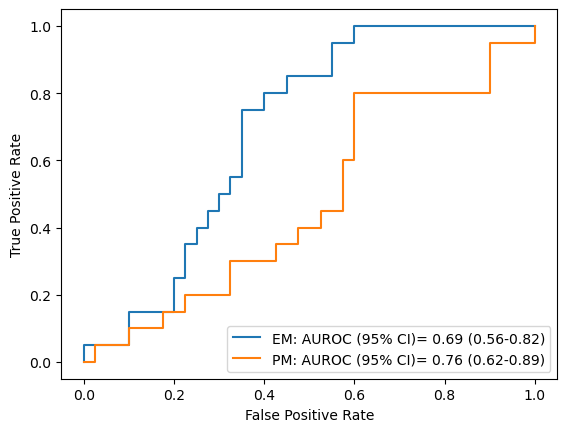

In [32]:
from sklearn import metrics
import matplotlib.pyplot as plt
fpr, tpr, _ = metrics.roc_curve(np.array(y_test_eval3c).astype(int),  y_pred3c[:, 1])

fpr_pm, tpr_pm, _ = metrics.roc_curve(np.array(y_test_eval1c).astype(int),  y_pred1c[:, 1])

#create ROC curve
plt.plot(fpr,tpr,label="EM: AUROC (95% CI)= "+auroc_results_df.loc['EM_LIME','FI*N_Values'])
plt.plot(fpr_pm,tpr_pm,label="PM: AUROC (95% CI)= "+auroc_results_df.loc['PM','Values'])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [33]:
#clf = RandomForestClassifier()
#eval_model3s = GridSearchCV(clf, param_grid, cv=5, n_jobs = n_defined_jobs)

eval_model3s = RandomForestRegressor(max_depth=2, random_state=0)
eval_model3s.fit(X_train_eval3s, y_train_eval3s)
save_model("eval_model3s", eval_model3s, X_test_eval3s, y_test_eval3s, features)

y_pred3s = eval_model3s.predict(X_test_eval3s)
#y_pred_classes3s =  eval_model3s.predict(X_test_eval3s)
#model_auc3s = roc_auc_score(y_test_eval3s, y_pred3s[:, 1])
#classificationReport3s = classification_report(y_test_eval3s, y_pred_classes3)

print("Results of Evaluation Model.3 for SHAP:")
#print("AUROC:")
#print(model_auc3s)
#print(classificationReport3s)

MSE3s = mean_squared_error(y_test_eval3[:, 1], y_pred3[:, 1])
RMSE3s = math.sqrt(MSE3s)
print("Root Mean Square Error:")
print(RMSE3s)
rmse_results_df.loc['EM_SHAP','FI*N_Values'] = RMSE3s 
#################################################

clf = RandomForestClassifier()
eval_model3sc = GridSearchCV(clf, param_grid, cv=5, n_jobs = n_defined_jobs) 
eval_model3sc.fit(X_train_eval3sc, y_train_eval3sc)
y_pred3sc = eval_model3sc.predict_proba(X_test_eval3sc)
y_pred_classes3sc =  eval_model3sc.predict(X_test_eval3sc)

# compare with Test Label: y_test_eval1c
model_auc3sc = roc_auc_score(y_test_eval3sc, y_pred3sc[:, 1])
classificationReport3sc = classification_report(y_test_eval3sc, y_pred_classes3sc)
print("AUROC:")
print(model_auc3sc)
print(classificationReport3sc)
auroc_results_df.loc['EM_SHAP','FI*N_Values'] = roc_auc_deLong_ci(np.array(y_test_eval3sc).astype(int), np.array(y_pred3sc[:, 1]))

Hostname: pw01ip0001
Results of Evaluation Model.3 for SHAP:
Root Mean Square Error:
0.18465314135004138
AUROC:
0.595
              precision    recall  f1-score   support

           0       0.67      1.00      0.80        40
           1       0.00      0.00      0.00        20

    accuracy                           0.67        60
   macro avg       0.33      0.50      0.40        60
weighted avg       0.44      0.67      0.53        60

AUC: 0.595
AUC COV: 0.0068158991228070166
95% AUC CI: [0.43318839 0.75681161]


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [34]:
auroc_results_df

,Values,FI,FI*Values,FI*N_Values
PM,0.76 (0.62-0.89),0.0,0.0,0.0
EM_LIME,0.0,0.48 (0.32-0.63),0.69 (0.55-0.82),0.69 (0.56-0.82)
EM_SHAP,0.0,0.38 (0.23-0.53),0.63 (0.47-0.78),0.6 (0.43-0.76)


In [35]:
rmse_results_df

,FI,FI*Values,FI*N_Values
EM_LIME,0.214764,0.185445,0.184653
EM_SHAP,0.230906,0.180708,0.184653


### BOXPLOT

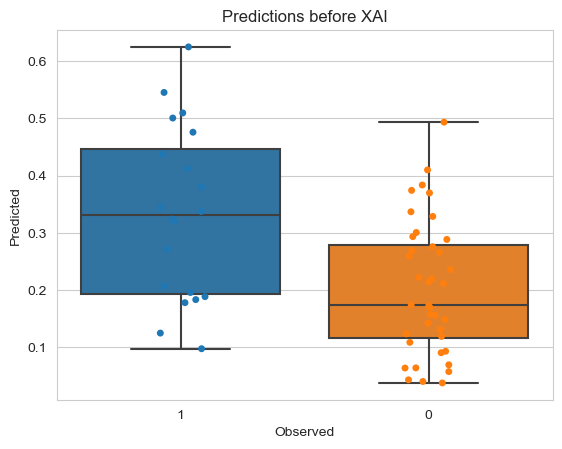

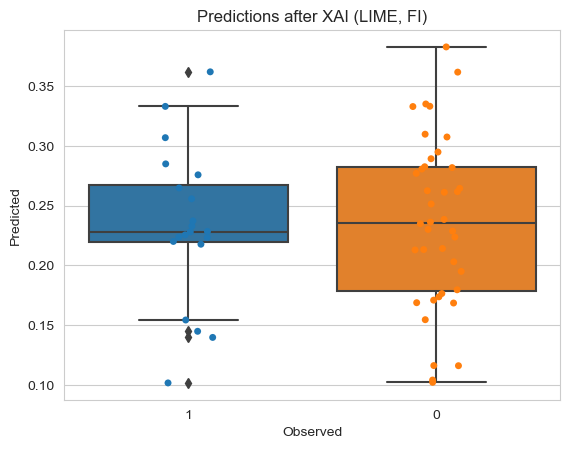

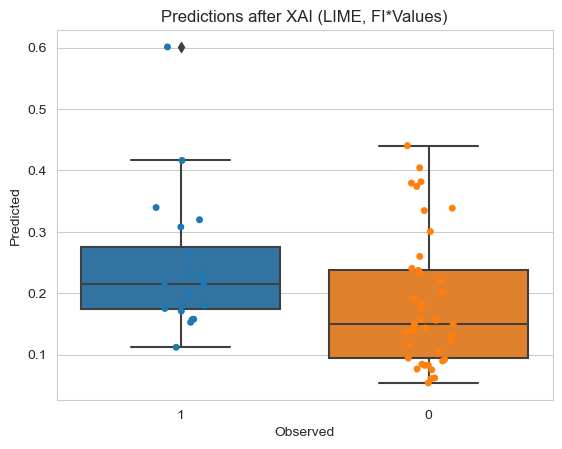

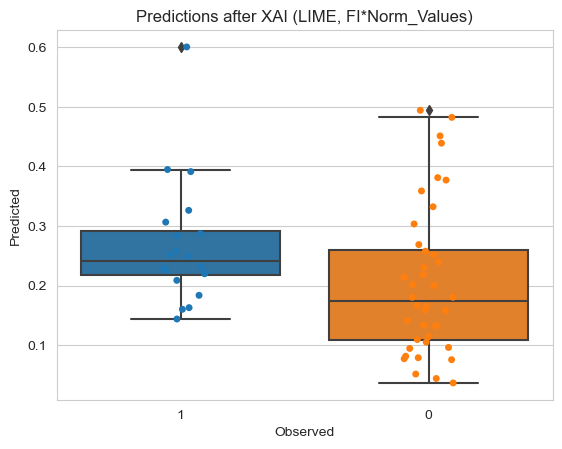

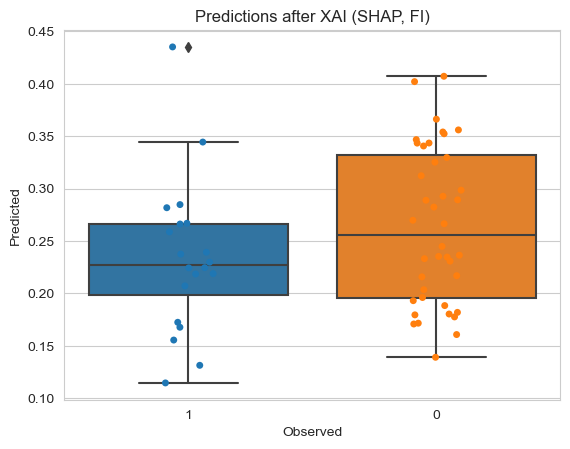

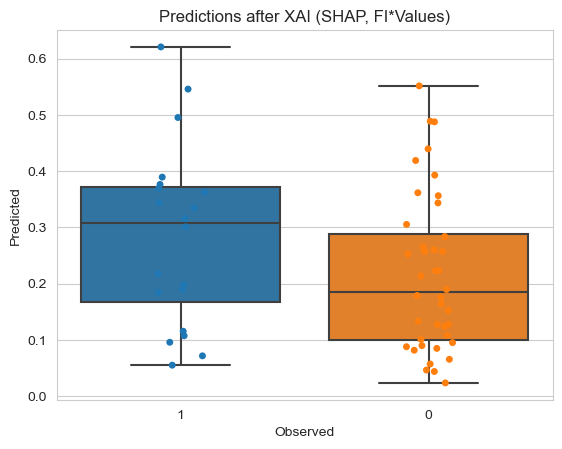

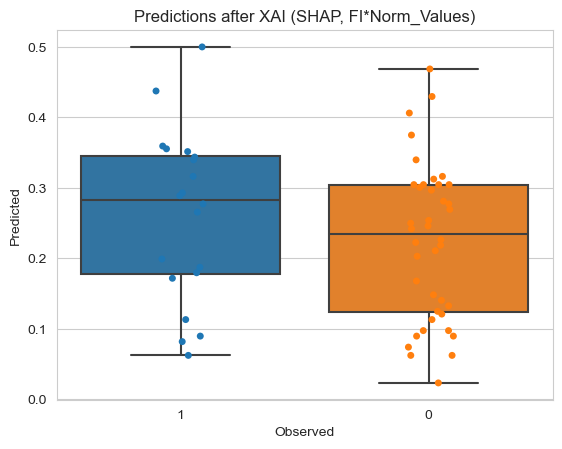

In [36]:
import seaborn as sns

# BEFORE
df_pred = pd.DataFrame(y_pred_rf3[:, 1], columns = ['Predicted'])
df_pred['Observed'] = y_test_rf3

sns.set_style('whitegrid')
ax = sns.boxplot(x='Observed',y='Predicted',data=df_pred)
ax = sns.stripplot(x="Observed", y="Predicted",data=df_pred)
plt.title("Predictions before XAI")
plt.show()



# AFTER.1: 
df_pred = pd.DataFrame(y_pred1c[:, 1], columns = ['Predicted'])
df_pred['Observed'] = y_test_eval1c

sns.set_style('whitegrid')
ax = sns.boxplot(x='Observed',y='Predicted',data=df_pred)
ax = sns.stripplot(x="Observed", y="Predicted",data=df_pred)
plt.title("Predictions after XAI (LIME, FI)")
plt.show()


# AFTER.2
df_pred = pd.DataFrame(y_pred2c[:, 1], columns = ['Predicted'])
df_pred['Observed'] = y_test_eval2c

sns.set_style('whitegrid')
ax= sns.boxplot(x='Observed',y='Predicted',data=df_pred)
ax = sns.stripplot(x="Observed", y="Predicted",data=df_pred)
plt.title("Predictions after XAI (LIME, FI*Values)")
plt.show()


# AFTER.3
df_pred = pd.DataFrame(y_pred3c[:, 1], columns = ['Predicted'])
df_pred['Observed'] = y_test_eval3c

sns.set_style('whitegrid')
ax= sns.boxplot(x='Observed',y='Predicted',data=df_pred)
ax = sns.stripplot(x="Observed", y="Predicted",data=df_pred)
plt.title("Predictions after XAI (LIME, FI*Norm_Values)")

plt.show()


# AFTER.4
df_pred = pd.DataFrame(y_pred1sc[:, 1], columns = ['Predicted'])
df_pred['Observed'] = y_test_eval1sc

sns.set_style('whitegrid')
ax= sns.boxplot(x='Observed',y='Predicted',data=df_pred)
ax = sns.stripplot(x="Observed", y="Predicted",data=df_pred)
plt.title("Predictions after XAI (SHAP, FI)")

plt.show()



# AFTER.5
df_pred = pd.DataFrame(y_pred2sc[:, 1], columns = ['Predicted'])
df_pred['Observed'] = y_test_eval2sc

sns.set_style('whitegrid')
ax= sns.boxplot(x='Observed',y='Predicted',data=df_pred)
ax = sns.stripplot(x="Observed", y="Predicted",data=df_pred)
plt.title("Predictions after XAI (SHAP, FI*Values)")

plt.show()

# AFTER.6
df_pred = pd.DataFrame(y_pred3sc[:, 1], columns = ['Predicted'])
df_pred['Observed'] = y_test_eval3sc

sns.set_style('whitegrid')
ax= sns.boxplot(x='Observed',y='Predicted',data=df_pred)
ax = sns.stripplot(x="Observed", y="Predicted",data=df_pred)
plt.title("Predictions after XAI (SHAP, FI*Norm_Values)")

plt.show()